In [1]:
import pandas as pd
import os
import time
import numpy as np
import torch

In [2]:
import seaborn as sns
from scipy import stats
from statistics import NormalDist
import matplotlib.pyplot as plt

In [3]:
#export
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [4]:
#! pip install dowhy
from dowhy import CausalModel
import dowhy.datasets, dowhy.plotter


In [5]:
import tensorflow as tf
#physical_devices = tf.config.list_physical_devices('CPU')
physical_devices = tf.config.list_physical_devices('GPU')

In [6]:
#device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device


device(type='cuda', index=0)

In [7]:
%matplotlib inline

# Confirmatory Causal Analysis
>
> Conformatory Experiments of Logits or Next Token Predictions @xxxxxp
>

### Data Upload

In [8]:
pd_combined_models_local = pd.read_csv('/workspaces/CodeSyntaxConcept/data/ds_processed_logits_local/out_astevalverticalfiltered_local.csv', index_col=0)  

In [9]:
pd_combined_models_local.shape

In [10]:
pd_combined_models_local.head(1)

,size,ast_levels,complexity,n_ast_nodes,for_statement,while_statement,return_statement,],),if_statement,...,for_in_clause,if_clause,list_comprehension,lambda,identifier,string,loss,id,type_model,size_model
0,280,13,7,154,0.0,0.0,0.0,0.457156,0.423305,0.587624,...,0.722651,0.0,0.0,0.0,0.382276,0.390246,1.79292,gpt-3 [125M],gpt-3,125M


In [11]:
confounders = [ 'size', 'ast_levels', 'complexity', 'n_ast_nodes']
performance = [
               'for_statement', 
               'while_statement', 
               'return_statement',
               ']', 
               ')', 
               'if_statement', 
               'comparison_operator', 
               'boolean_operator',
               'for_in_clause', 
               'if_clause', 
               'list_comprehension', 
               'lambda',
               'identifier', 
               'string', 
               ]
outcome = ['loss']
features = ['id', 'type_model', 'size_model' ]

In [24]:
list_model = set(pd_combined_models_local.id.values)
list_model

{'codegen-nl [2B]',
 'codegen-nl [350M]',
 'gpt-3 [1.3B]',
 'gpt-3 [125M]',
 'gpt-3 [2.7B]',
 'mono-lang [1.5B]',
 'mono-lang [110M]',
 'mono-lang [2B]',
 'mono-lang [350M]',
 'multi-lang [110M]',
 'multi-lang [2B]',
 'multi-lang [350M]'}

In [12]:
list_model = {'gpt-3 [125M]','mono-lang [2B]'} #Considering only edge cases

In [15]:
#Avg ASC Concept Performance
pd_combined_models_local['asc_performance'] = pd_combined_models_local[performance].apply(np.mean ,axis=1 )

In [16]:
pd_combined_models_local.head(1)

,size,ast_levels,complexity,n_ast_nodes,for_statement,while_statement,return_statement,],),if_statement,...,if_clause,list_comprehension,lambda,identifier,string,loss,id,type_model,size_model,asc_performance
0,280,13,7,154,0.0,0.0,0.0,0.457156,0.423305,0.587624,...,0.0,0.0,0.0,0.382276,0.390246,1.79292,gpt-3 [125M],gpt-3,125M,0.2225


## Descriptive Statistics

In [10]:
sns.set_theme(style="darkgrid")

In [11]:
pd_combined_models_local.groupby(['id']).describe() #.reset_index()

size                                                     \
                     count        mean         std   min    25%    50%    75%   
id                                                                              
codegen-nl [2B]    50971.0  298.967825  218.413483  65.0  131.0  227.0  403.0   
codegen-nl [350M]  50971.0  298.967825  218.413483  65.0  131.0  227.0  403.0   
gpt-3 [1.3B]       50971.0  298.967825  218.413483  65.0  131.0  227.0  403.0   
gpt-3 [125M]       50971.0  298.967825  218.413483  65.0  131.0  227.0  403.0   
gpt-3 [2.7B]       50971.0  298.967825  218.413483  65.0  131.0  227.0  403.0   
mono-lang [1.5B]   50971.0  169.580095  121.304824  25.0   79.0  131.0  224.0   
mono-lang [110M]   50971.0  169.580095  121.304824  25.0   79.0  131.0  224.0   
mono-lang [2B]     50971.0  200.874615  142.830179  31.0   93.0  155.0  266.0   
mono-lang [350M]   50971.0  200.874615  142.830179  31.0   93.0  155.0  266.0   
multi-lang [110M]  50971.0  172.468561  123.302573  25.0   80.0  133.0  228.0   
multi-lang [2B]    50971.0  200.874615  142.830179  31.0   93.0  155.0  266.0   
multi-lang [350M]  50971.0  200.874615  142.830179  31.0   93.0  155.0  266.0   

                          ast_levels             ...    string            \
                      max      count       mean  ...       75%       max   
id                                               ...                       
codegen-nl [2B]    1023.0    50971.0  12.081144  ...  0.598134  0.985791   
codegen-nl [350M]  1023.0    50971.0  12.081144  ...  0.513648  0.978898   
gpt-3 [1.3B]       1023.0    50971.0  12.081144  ...  0.552412  0.979513   
gpt-3 [125M]       1023.0    50971.0  12.081144  ...  0.455816  0.976738   
gpt-3 [2.7B]       1023.0    50971.0  12.081144  ...  0.577822  0.989621   
mono-lang [1.5B]    813.0    50971.0  12.081144  ...  0.706214  0.999646   
mono-lang [110M]    813.0    50971.0  12.081144  ...  0.582083  0.988427   
mono-lang [2B]      960.0    50971.0  12.081144  ...  0.794385  0.999952   
mono-lang [350M]    960.0    50971.0  12.081144  ...  0.672733  0.998424   
multi-lang [110M]   842.0    50971.0  12.081144  ...  0.529325  0.988157   
multi-lang [2B]     960.0    50971.0  12.081144  ...  0.745257  0.999804   
multi-lang [350M]   960.0    50971.0  12.081144  ...  0.624931  0.991980   

                      loss                                                    \
                     count      mean       std       min       25%       50%   
id                                                                             
codegen-nl [2B]    50971.0  1.020236  0.384616  0.128273  0.746897  0.966013   
codegen-nl [350M]  50971.0  1.261825  0.438032  0.159787  0.946027  1.203984   
gpt-3 [1.3B]       50971.0  1.134710  0.408845  0.140364  0.842746  1.079721   
gpt-3 [125M]       50971.0  1.460342  0.486276  0.170204  1.106806  1.400762   
gpt-3 [2.7B]       50971.0  1.076377  0.397994  0.127384  0.794475  1.020980   
mono-lang [1.5B]   50971.0  1.396434  0.634001  0.061886  0.936434  1.344448   
mono-lang [110M]   50971.0  1.643401  0.537986  0.174793  1.267869  1.593241   
mono-lang [2B]     50971.0  1.003580  0.490924  0.055171  0.641252  0.956290   
mono-lang [350M]   50971.0  1.236525  0.469514  0.095004  0.903838  1.185783   
multi-lang [110M]  50971.0  1.839165  0.519712  0.378433  1.481195  1.796652   
multi-lang [2B]    50971.0  1.064453  0.462305  0.077227  0.731439  1.018419   
multi-lang [350M]  50971.0  1.324379  0.445469  0.129052  1.013137  1.279475   

                                       
                        75%       max  
id                                     
codegen-nl [2B]    1.224977  3.708745  
codegen-nl [350M]  1.511394  3.849970  
gpt-3 [1.3B]       1.360375  3.655161  
gpt-3 [125M]       1.748380  4.022199  
gpt-3 [2.7B]       1.293123  3.515066  
mono-lang [1.5B]   1.771850  5.277113  
mono-lang [110M]   1.960236  4.508049  
mono-lang [2B]     1.286481  4.988358  
mono-lang [350M]   1.504

## Correlation Analysis

In [18]:
def pearson(np_x, np_y):
    corr, p_val = stats.pearsonr(np_x, np_y)
    #logging.info( f"correlation:{corr} pval:{p_val}" )
    return corr

In [16]:
correlations_performance = { col: [ [model, 
                                pearson( pd_combined_models_local[pd_combined_models_local['id']==model][col].values, pd_combined_models_local[pd_combined_models_local['id']==model]['loss'].values ), 
                                pearson( pd_combined_models_local[pd_combined_models_local['id']==model][col].values, pd_combined_models_local[pd_combined_models_local['id']==model]['complexity'].values ),
                                pearson( pd_combined_models_local[pd_combined_models_local['id']==model][col].values, pd_combined_models_local[pd_combined_models_local['id']==model]['ast_levels'].values ),
                                pearson( pd_combined_models_local[pd_combined_models_local['id']==model][col].values, pd_combined_models_local[pd_combined_models_local['id']==model]['n_ast_nodes'].values ),     
                                pearson( pd_combined_models_local[pd_combined_models_local['id']==model][col].values, pd_combined_models_local[pd_combined_models_local['id']==model]['size'].values)] for model in list_model]  for col in performance }

In [17]:
correlations_performance

{'for_statement': [['gpt-3 [125M]',
   -0.16211393619293266,
   0.3235626597835413,
   0.30460842110380704,
   0.18370611680127166,
   0.22877780981277374],
  ['mono-lang [2B]',
   -0.07318307286503221,
   0.3179092903215956,
   0.2950803252960029,
   0.18637118342439746,
   0.1906335403734808]],
 'while_statement': [['gpt-3 [125M]',
   -0.048610834453165226,
   0.13357768749965307,
   0.07594467940041492,
   0.0524903140505574,
   0.06731408178618599],
  ['mono-lang [2B]',
   -0.028217580752089157,
   0.13162540374394377,
   0.07388776248624894,
   0.05216778297144384,
   0.05027869191853014]],
 'return_statement': [['gpt-3 [125M]',
   -0.037904758560968956,
   0.271101164595025,
   0.05999895509764001,
   -0.05759904443601157,
   -0.006605561841546734],
  ['mono-lang [2B]',
   -0.029237229164546494,
   0.33410685272976254,
   0.08569077709276458,
   -0.03181652861333318,
   -0.00391397478364932]],
 ']': [['gpt-3 [125M]',
   -0.15661114749177688,
   0.16184895750848477,
   0.213638760

In [18]:
correlations_loss = { col: [ [model, 
                                pearson( pd_combined_models_local[pd_combined_models_local['id']==model][col].values, pd_combined_models_local[pd_combined_models_local['id']==model]['loss'].values )] for model in list_model]  for col in confounders }

In [19]:
correlations_loss

{'size': [['gpt-3 [125M]', -0.4933673218663951],
  ['mono-lang [2B]', -0.37232255524390445]],
 'ast_levels': [['gpt-3 [125M]', -0.27611559995889273],
  ['mono-lang [2B]', -0.19279511111074762]],
 'complexity': [['gpt-3 [125M]', -0.17294576353371302],
  ['mono-lang [2B]', -0.0906980865158081]],
 'n_ast_nodes': [['gpt-3 [125M]', -0.40599288078271895],
  ['mono-lang [2B]', -0.38452222255793733]]}

In [19]:
asc_performance = { col: [ [model, 
                                pearson( pd_combined_models_local[pd_combined_models_local['id']==model][col].values, pd_combined_models_local[pd_combined_models_local['id']==model]['loss'].values ), 
                                pearson( pd_combined_models_local[pd_combined_models_local['id']==model][col].values, pd_combined_models_local[pd_combined_models_local['id']==model]['complexity'].values ),
                                pearson( pd_combined_models_local[pd_combined_models_local['id']==model][col].values, pd_combined_models_local[pd_combined_models_local['id']==model]['ast_levels'].values ),
                                pearson( pd_combined_models_local[pd_combined_models_local['id']==model][col].values, pd_combined_models_local[pd_combined_models_local['id']==model]['n_ast_nodes'].values ),     
                                pearson( pd_combined_models_local[pd_combined_models_local['id']==model][col].values, pd_combined_models_local[pd_combined_models_local['id']==model]['size'].values)] for model in list_model]  for col in ['asc_performance'] }

In [20]:
asc_performance

{'asc_performance': [['mono-lang [2B]',
   -0.3786016078626545,
   0.6016017343285318,
   0.44729382973638554,
   0.4679724238324324,
   0.476297717637667],
  ['gpt-3 [125M]',
   -0.3840956854681688,
   0.6119245529909374,
   0.4116812288005214,
   0.5118538457050751,
   0.5266347579536274]]}

## Causation Analysis

In [22]:
def causal_effect(
    df_data = pd_combined_models_local[pd_combined_models_local['id']=='gpt-3 [125M]'],
    treatment = ['for_statement'],
    outcome = ['loss'],
    common_causes = ["size"]
):
    '''
    Returns Causal Effect 
    placebo robust method
    random common cause variable
    '''
    # I. Create a causal model from the data and given graph.
    causal_model = CausalModel(
        data =  df_data, 
        treatment = treatment,
        outcome = outcome,
        common_causes = common_causes
        )
    # II. Identify causal effect and return target estimands
    identified_estimand = causal_model.identify_effect(proceed_when_unidentifiable=True)
    
    # III. Estimate the target estimand using a statistical method.
    propensity_strat_estimate = causal_model.estimate_effect(identified_estimand,
                                 method_name="backdoor.dowhy.linear_regression")
    
    # IV. Refute the obtained estimate using multiple robustness checks.
    refute_results = causal_model.refute_estimate(identified_estimand, propensity_strat_estimate,
                                       method_name="placebo_treatment_refuter")
    
    res_random=causal_model.refute_estimate(identified_estimand, propensity_strat_estimate, method_name="random_common_cause")

    
    return propensity_strat_estimate.value, refute_results.new_effect, res_random.new_effect 

In [21]:
#TST
causal_eff, res_placebo, res_random = causal_effect()
print(causal_eff, res_placebo, res_random )

2023-05-01 21:54:07,578 : WARNING : Causal Graph not provided. DoWhy will construct a graph based on data inputs.
2023-05-01 21:54:07,581 : INFO : Model to find the causal effect of treatment ['for_statement'] on outcome ['loss']
2023-05-01 21:54:07,585 : INFO : Causal effect can be identified.
2023-05-01 21:54:07,590 : INFO : Instrumental variables for treatment and outcome:[]
2023-05-01 21:54:07,590 : INFO : Frontdoor variables for treatment and outcome:[]
2023-05-01 21:54:07,591 : INFO : INFO: Using Linear Regression Estimator
2023-05-01 21:54:07,597 : INFO : b: loss~for_statement+size
2023-05-01 21:54:07,648 : INFO : Refutation over 100 simulated datasets of PlaceboType.DEFAULT treatment
2023-05-01 21:54:07,651 : INFO : Using a Normal Distribution with Mean:0 and Variance:0
2023-05-01 21:54:07,678 : INFO : b: loss~placebo+size
/usr/local/lib/python3.8/dist-packages/statsmodels/regression/linear_model.py:1934: RuntimeWarning: divide by zero encountered in double_scalars
  return np.

-0.10226495848259742 0.0 -0.10226139521563148


In [14]:
causation_concepts = { col: [ [model, 
                                causal_effect( 
                                              df_data = pd_combined_models_local[pd_combined_models_local['id']==model], 
                                              treatment = [col], 
                                              outcome = outcome,
                                              common_causes = confounders #controlling all confounders
                                              ), \
                            ] for model in list_model]  for col in performance }

2023-05-01 22:12:55,855 : WARNING : Causal Graph not provided. DoWhy will construct a graph based on data inputs.
2023-05-01 22:12:55,857 : INFO : Model to find the causal effect of treatment ['for_statement'] on outcome ['loss']
2023-05-01 22:12:55,861 : INFO : Causal effect can be identified.
2023-05-01 22:12:55,864 : INFO : Instrumental variables for treatment and outcome:[]
2023-05-01 22:12:55,864 : INFO : Frontdoor variables for treatment and outcome:[]
2023-05-01 22:12:55,865 : INFO : INFO: Using Linear Regression Estimator
2023-05-01 22:12:55,870 : INFO : b: loss~for_statement+n_ast_nodes+ast_levels+size+complexity
2023-05-01 22:12:55,906 : INFO : Refutation over 100 simulated datasets of PlaceboType.DEFAULT treatment
2023-05-01 22:12:55,909 : INFO : Using a Normal Distribution with Mean:0 and Variance:0
2023-05-01 22:12:55,922 : INFO : b: loss~placebo+n_ast_nodes+ast_levels+size+complexity
2023-05-01 22:12:55,954 : INFO : Using a Normal Distribution with Mean:0 and Variance:0
2

In [16]:
causation_concepts

{'for_statement': [['mono-lang [2B]',
   (-0.011160528027547079, 0.0, -0.011159029367755565)],
  ['gpt-3 [125M]',
   (-0.0999767560011704, 7.593925488436071e-14, -0.09997484496587183)]],
 'while_statement': [['mono-lang [2B]',
   (-0.07854900401209042, 0.0, -0.07853397835322416)],
  ['gpt-3 [125M]',
   (-0.10728039909789544, 7.593925488436071e-14, -0.1072868844062286)]],
 'return_statement': [['mono-lang [2B]',
   (-0.08901007269656469, 0.0, -0.08901125086011151)],
  ['gpt-3 [125M]',
   (-0.09475767960706971, 7.593925488436071e-14, -0.09475667209596654)]],
 ']': [['mono-lang [2B]', (-0.10439308392248836, 0.0, -0.10439403645307926)],
  ['gpt-3 [125M]',
   (-0.04131180922941802, 7.593925488436071e-14, -0.041304893109789145)]],
 ')': [['mono-lang [2B]', (-1.4856132291131008, 0.0, -1.4856105910571722)],
  ['gpt-3 [125M]',
   (-0.8454216082810531, 7.593925488436071e-14, -0.8454252177461449)]],
 'if_statement': [['mono-lang [2B]',
   (-0.10723090245216638, 0.0, -0.10723300597202994)],
  ['gp

In [23]:
causation_asc = { col: [ [model, 
                                causal_effect( 
                                              df_data = pd_combined_models_local[pd_combined_models_local['id']==model], 
                                              treatment = [col], 
                                              outcome = outcome,
                                              common_causes = confounders #controlling all confounders
                                              ), \
                            ] for model in list_model]  for col in ['asc_performance'] }

2023-05-01 23:54:16,865 : WARNING : Causal Graph not provided. DoWhy will construct a graph based on data inputs.
2023-05-01 23:54:16,866 : INFO : Model to find the causal effect of treatment ['asc_performance'] on outcome ['loss']
2023-05-01 23:54:16,870 : INFO : Causal effect can be identified.
2023-05-01 23:54:16,873 : INFO : Instrumental variables for treatment and outcome:[]
2023-05-01 23:54:16,874 : INFO : Frontdoor variables for treatment and outcome:[]
2023-05-01 23:54:16,874 : INFO : INFO: Using Linear Regression Estimator
2023-05-01 23:54:16,878 : INFO : b: loss~asc_performance+n_ast_nodes+complexity+ast_levels+size
2023-05-01 23:54:16,918 : INFO : Refutation over 100 simulated datasets of PlaceboType.DEFAULT treatment
2023-05-01 23:54:16,921 : INFO : Using a Normal Distribution with Mean:0 and Variance:0
2023-05-01 23:54:16,934 : INFO : b: loss~placebo+n_ast_nodes+complexity+ast_levels+size
2023-05-01 23:54:16,965 : INFO : Using a Normal Distribution with Mean:0 and Variance

In [24]:
causation_asc

{'asc_performance': [['mono-lang [2B]',
   (-1.7797846757844942, 3.086420008457935e-14, -1.7797823695684678)],
  ['gpt-3 [125M]', (-1.5975233310263426, 0.0, -1.597525316408948)]]}

### Visual Correlations

In [17]:
#Check here: https://seaborn.pydata.org/generated/seaborn.pairplot.html
g = sns.pairplot(data=pd_combined_models_local[performance+outcome])
g.map_upper(sns.scatterplot,marker=".")
g.map_lower(sns.kdeplot,levels=3,color=".2")
g.map_diag(sns.histplot)

<AxesSubplot:xlabel='asc_performance', ylabel='loss'>

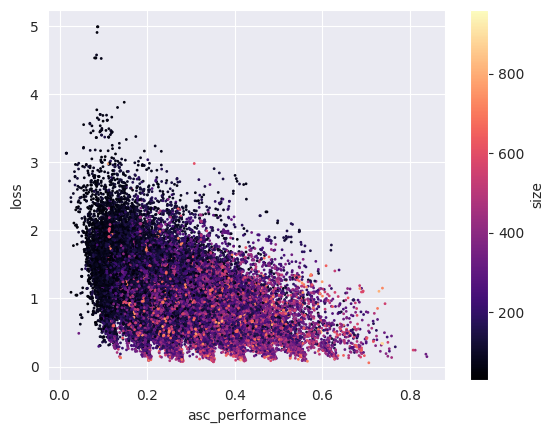

In [25]:
sns.set_style("darkgrid")
pd_combined_models_local[pd_combined_models_local['id']=='mono-lang [2B]'].plot.scatter(
    x = 'asc_performance',
    y = 'loss',
    c = 'size', #Common Causes
    s = 1,
    cmap="magma" #cmap="viridis" plasma
)


<AxesSubplot:xlabel='asc_performance', ylabel='loss'>

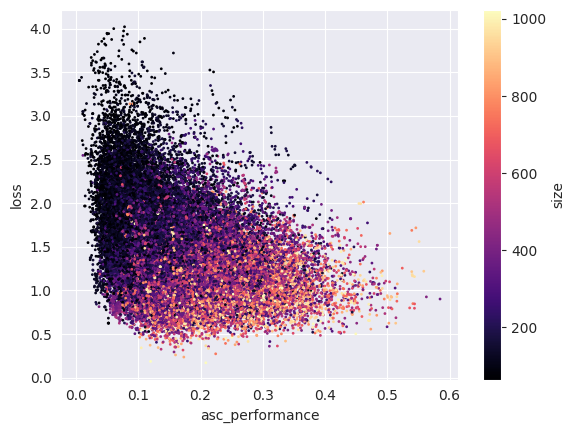

In [26]:
pd_combined_models_local[pd_combined_models_local['id']=='gpt-3 [125M]'].plot.scatter(
    x = 'asc_performance',
    y = 'loss',
    c = 'size', #Common Causes
    s = 1,
    cmap="magma" #cmap="viridis" plasma
)

<AxesSubplot:xlabel='asc_performance', ylabel='loss'>

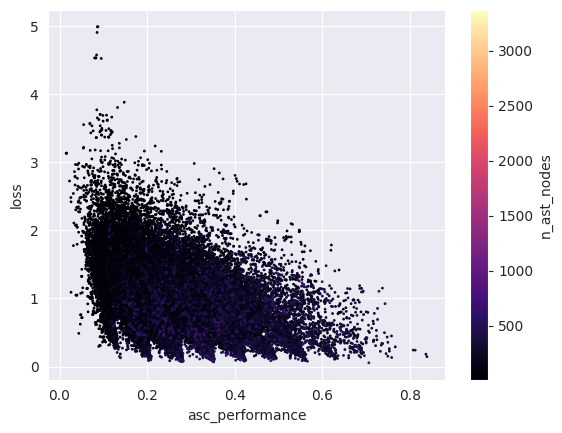

In [27]:
sns.set_style("darkgrid")
pd_combined_models_local[pd_combined_models_local['id']=='mono-lang [2B]'].plot.scatter(
    x = 'asc_performance',
    y = 'loss',
    c = 'n_ast_nodes', #Common Causes
    s = 1,
    cmap="magma" #cmap="viridis" plasma
)

<AxesSubplot:xlabel='complexity', ylabel='asc_performance'>

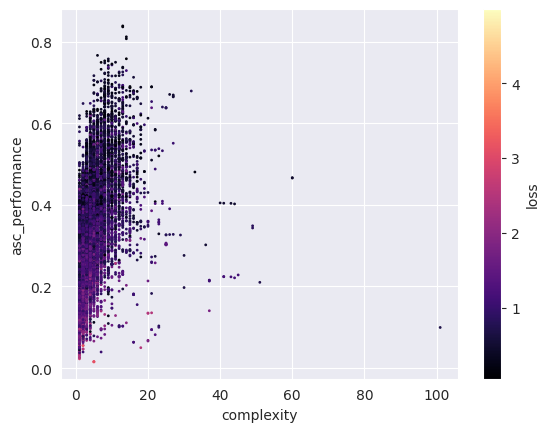

In [28]:
pd_combined_models_local[pd_combined_models_local['id']=='mono-lang [2B]'].plot.scatter(
    x = 'complexity',
    y = 'asc_performance',
    c = 'loss', #Common Causes
    s = 1,
    cmap="magma" #cmap="viridis" plasma
)

<AxesSubplot:xlabel='size', ylabel='function_definition'>

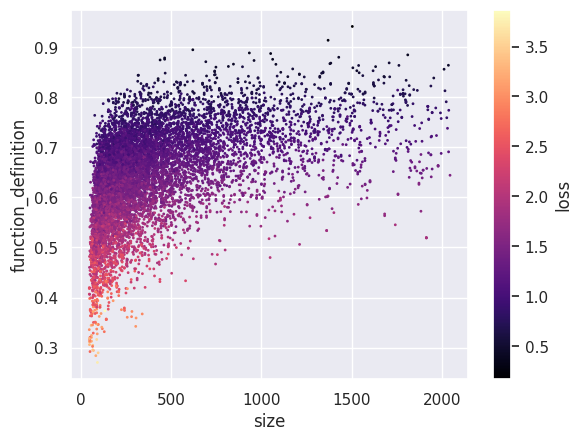

In [54]:
pd_processed_logits[pd_processed_logits['model']=='125M'].plot.scatter(
    y = 'function_definition',
    x = 'size',
    c = 'loss', #Common Causes
    s = 1,
    cmap="magma" #cmap="viridis" plasma
)

<AxesSubplot:xlabel='size', ylabel='function_definition'>

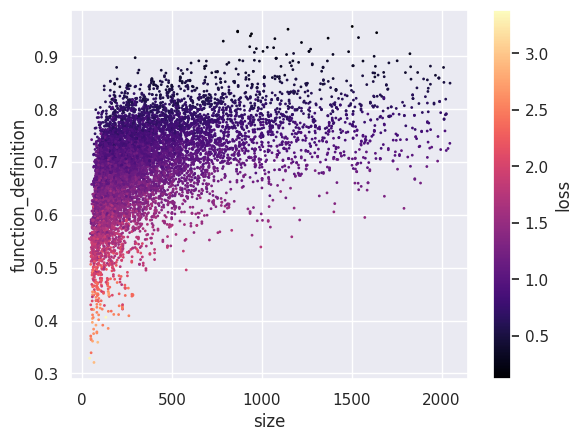

In [23]:
pd_processed_logits[pd_processed_logits['model']=='1.3B'].plot.scatter(
    y = 'function_definition',
    x = 'size',
    c = 'loss', #Common Causes
    s = 1,
    cmap="magma" #cmap="viridis" plasma
)

<AxesSubplot:xlabel='size', ylabel='function_definition'>

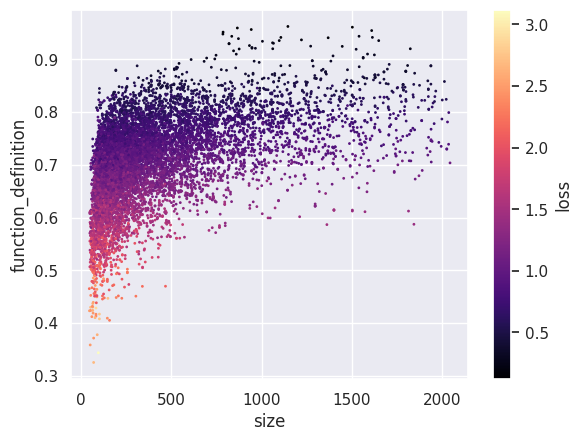

In [24]:
pd_processed_logits[pd_processed_logits['model']=='2.7B'].plot.scatter(
    y = 'function_definition',
    x = 'size',
    c = 'loss', #Common Causes
    s = 1,
    cmap="magma" #cmap="viridis" plasma
)

<AxesSubplot:xlabel='expression_statement', ylabel='loss'>

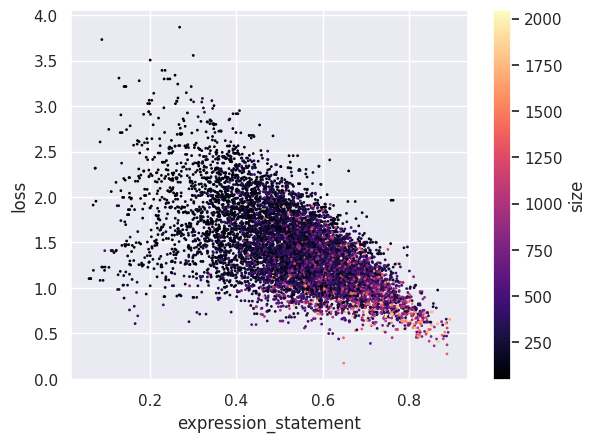

In [20]:
#Check here for more plots: https://seaborn.pydata.org/tutorial/regression.html
#g = sns.relplot(data=data['df'], x="v0", y="y")
pd_processed_logits[pd_processed_logits['model']=='125M'].plot.scatter(
    x = 'expression_statement',
    y = 'loss',
    c = 'size', #Common Causes
    s = 1,
    cmap="magma" #cmap="viridis" plasma
)

<AxesSubplot:xlabel='expression_statement', ylabel='loss'>

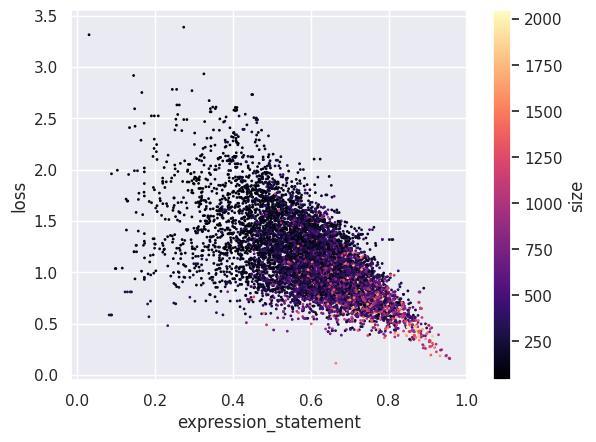

In [21]:
pd_processed_logits[pd_processed_logits['model']=='1.3B'].plot.scatter(
    x = 'expression_statement',
    y = 'loss',
    c = 'size', #Common Causes
    s = 1,
    cmap="magma" #cmap="viridis" plasma
)

<AxesSubplot:xlabel='expression_statement', ylabel='loss'>

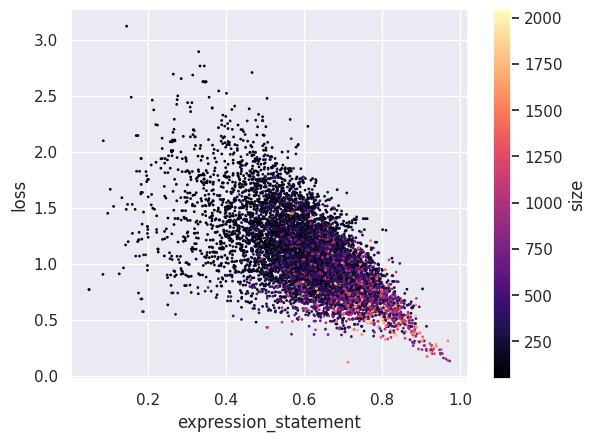

In [22]:
pd_processed_logits[pd_processed_logits['model']=='2.7B'].plot.scatter(
    x = 'expression_statement',
    y = 'loss',
    c = 'size', #Common Causes
    s = 1,
    cmap="magma" #cmap="viridis" plasma
)

<AxesSubplot:xlabel='expression_statement', ylabel='loss'>

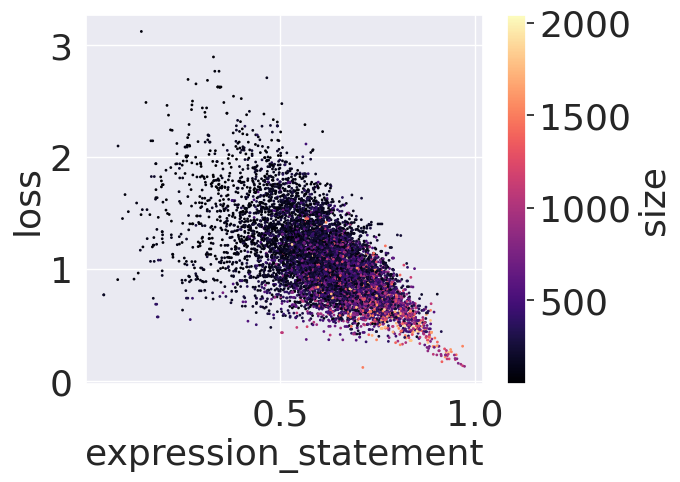

In [43]:
pd_processed_logits[pd_processed_logits['model']=='2.7B'].plot.scatter(
    x = 'expression_statement',
    y = 'loss',
    c = 'size', #Common Causes
    s = 1,
    cmap="magma" #cmap="viridis" plasma
)

## Causal Analysis (implementation)

In [41]:
# Testing Block
def causal_data( ):
    data = dowhy.datasets.linear_dataset(
        beta=2,
        num_common_causes=20,
        num_instruments=0,
        num_samples=10000,
        treatment_is_binary=False,
        stddev_treatment_noise = 10 )
    
    return data

In [46]:
pd_processed_logits[pd_processed_logits['model']=='125M'].head(1)

,identifier,.,(,),",",=,string,:,[,],...,assignment,comparison_operator,if_statement,return_statement,for_statement,parameters,function_definition,size,loss,model
0,0.412516,0.299358,0.314944,0.321358,0.53304,0.893485,0.574881,0.486578,0.091341,0.035271,...,0.331766,0.0,0.820863,0.478713,0.0,0.161232,0.681596,154,1.089324,125M


In [ ]:
def causal_effect(
    df_data = pd_processed_logits[pd_processed_logits['model']=='125M'],
    treatment = ['attribute'],
    outcome = ['loss'],
    common_causes = ["size"]
):
    '''
    Returns Causal Effect and placebo robust method
    '''
    # I. Create a causal model from the data and given graph.
    causal_model = CausalModel(
        data =  df_data, 
        treatment = treatment,
        outcome = outcome,
        common_causes = common_causes
        )
    # II. Identify causal effect and return target estimands
    identified_estimand = causal_model.identify_effect(proceed_when_unidentifiable=True)
    
    # III. Estimate the target estimand using a statistical method.
    propensity_strat_estimate = causal_model.estimate_effect(identified_estimand,
                                 method_name="backdoor.dowhy.linear_regression")
    
    # IV. Refute the obtained estimate using multiple robustness checks.
    refute_results = causal_model.refute_estimate(identified_estimand, propensity_strat_estimate,
                                       method_name="placebo_treatment_refuter")
    
    res_random=causal_model.refute_estimate(identified_estimand, propensity_strat_estimate, method_name="random_common_cause")

    
    return propensity_strat_estimate.value, refute_results.new_effect, res_random.new_effect 
    

In [26]:
# I. Create a causal model from the data and given graph.
causal_model = CausalModel(
    data =  pd_processed_logits[pd_processed_logits['model']=='125M'], #data["df"],
    treatment = ['attribute'],
    outcome = ['loss'],
    common_causes = ["size"]
    #instruments=data["instrument_names"]
    )

2023-03-14 02:13:23,761 : WARNING : Causal Graph not provided. DoWhy will construct a graph based on data inputs.
2023-03-14 02:13:23,762 : INFO : Model to find the causal effect of treatment ['attribute'] on outcome ['loss']


In [27]:
# II. Identify causal effect and return target estimands
identified_estimand = causal_model.identify_effect(proceed_when_unidentifiable=True)
logging.info(identified_estimand)

2023-03-14 02:13:47,739 : INFO : Causal effect can be identified.
2023-03-14 02:13:47,742 : INFO : Instrumental variables for treatment and outcome:[]
2023-03-14 02:13:47,743 : INFO : Frontdoor variables for treatment and outcome:[]
2023-03-14 02:13:47,743 : INFO : Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                    
────────────(E[loss|size])
d[attribute]              
Estimand assumption 1, Unconfoundedness: If U→{attribute} and U→loss then P(loss|attribute,size,U) = P(loss|attribute,size)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [28]:
# III. Estimate the target estimand using a statistical method.
propensity_strat_estimate = causal_model.estimate_effect(identified_estimand,
                                 method_name="backdoor.dowhy.linear_regression")

print(propensity_strat_estimate)

2023-03-14 02:13:47,834 : INFO : INFO: Using Linear Regression Estimator
2023-03-14 02:13:47,840 : INFO : b: loss~attribute+size


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                    
────────────(E[loss|size])
d[attribute]              
Estimand assumption 1, Unconfoundedness: If U→{attribute} and U→loss then P(loss|attribute,size,U) = P(loss|attribute,size)

## Realized estimand
b: loss~attribute+size
Target units: ate

## Estimate
Mean value: -0.6714044288111154



In [34]:
propensity_strat_estimate.value 

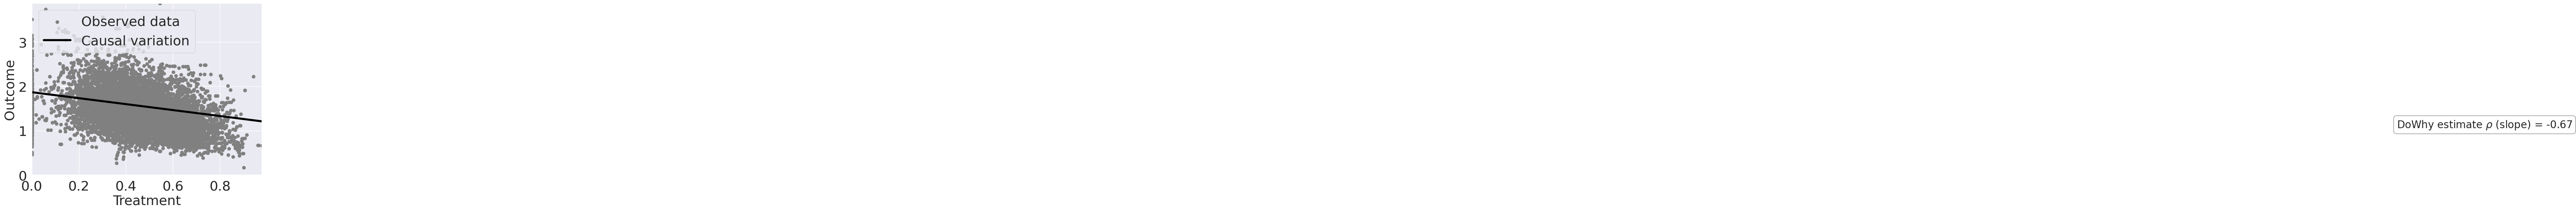

In [37]:
dowhy.plotter.plot_causal_effect(
    propensity_strat_estimate, 
    pd_processed_logits[pd_processed_logits['model']=='125M']['attribute'], 
    pd_processed_logits[pd_processed_logits['model']=='125M']['loss']
    )  

<AxesSubplot:xlabel='attribute', ylabel='loss'>

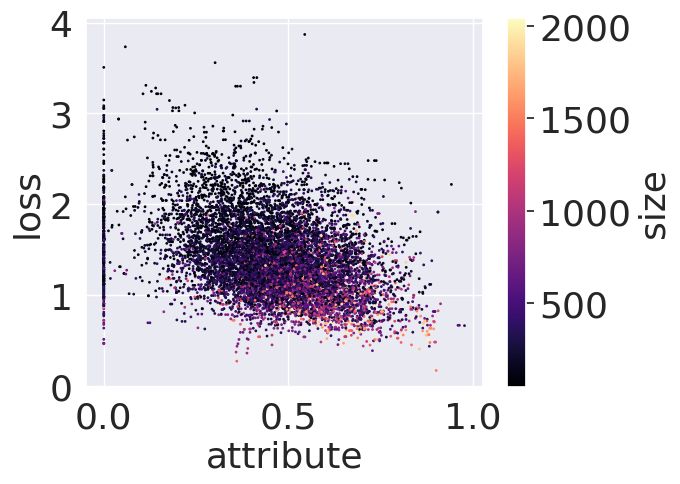

In [45]:
sns.set_style("darkgrid")
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
plt.rcParams.update({'font.size': 22})


pd_processed_logits[pd_processed_logits['model']=='125M'].plot.scatter(
    x = 'attribute',
    y = 'loss',
    c = 'size', #Common Causes
    s = 1,
    cmap="magma" #cmap="viridis" plasma
)

In [29]:
# IV. Refute the obtained estimate using multiple robustness checks.
refute_results = causal_model.refute_estimate(identified_estimand, propensity_strat_estimate,
                                       method_name="placebo_treatment_refuter")
print(refute_results)

2023-03-14 02:13:48,003 : INFO : Refutation over 100 simulated datasets of PlaceboType.DEFAULT treatment
2023-03-14 02:13:48,007 : INFO : Using a Normal Distribution with Mean:0 and Variance:0
2023-03-14 02:13:48,016 : INFO : b: loss~placebo+size
/usr/local/lib/python3.8/dist-packages/statsmodels/regression/linear_model.py:1934: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
2023-03-14 02:13:48,034 : INFO : Using a Normal Distribution with Mean:0 and Variance:0
2023-03-14 02:13:48,039 : INFO : b: loss~placebo+size
/usr/local/lib/python3.8/dist-packages/statsmodels/regression/linear_model.py:1934: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
2023-03-14 02:13:48,056 : INFO : Using a Normal Distribution with Mean:0 and Variance:0
2023-03-14 02:13:48,060 : INFO : b: loss~placebo+size
/usr/local/lib/python3.8/dist-packages/statsmodels/regression/linear_model.py:1934: RuntimeWarnin

Refute: Use a Placebo Treatment
Estimated effect:-0.6714044288111154
New effect:0.0
p value:2.0



In [49]:
refute_results.new_effect